In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import pickle
import pickle5 as pickle
from gurobipy import *
from gurobipy import GRB
import time
import csv
from collections import defaultdict
import sys
import re

In [2]:
# read facility points
facility = pd.read_csv('data/facility.csv')
print(facility.shape)

# read demand
demand = pd.read_csv('data/demand.csv')
print(demand.shape)

# read distance matrix
distance_matrix = np.genfromtxt('data/dist.txt')
print(distance_matrix.shape)

(831, 1)
(3548, 2)
(831, 3548)


In [3]:
demand.head()

,geo_id,flat_cnt
0,0,80.0
1,1,149.0
2,2,16.0
3,3,83.0
4,4,20.0


In [4]:
# fill in NAs 
demand.fillna(0, inplace=True)

In [5]:
# prep matrix to dict 

def get_covered(r):
    """For each facility find the demand points that are covered given 
    a distance threshold radius (r)
    
    r(int) - radius 

    saves: covered in dict format like so:
    1: [1,2,3]
    2: [1]

    """
    dist_matrix = np.genfromtxt('data/dist.txt')

    print(dist_matrix.shape)

    rows = dist_matrix.shape[0]
    cols = dist_matrix.shape[1]

    lst_array = []
    #dict_fac = {}
    dict_fac = defaultdict(list)
    dict_dem = {}

    for i in range(0,rows): # for each potential facility (n=100)
        for j in range(0,cols): # for each demand point (n=50)
            lst_array.append([i,j,dist_matrix[i,j]])
            #print(i, j, dist_matrix[i,j])
            
            # if within threshold add to dictionary 
            if dist_matrix[i,j]<=r: 
                dict_fac[i].append(j)
    
    with open('data/covered.pickle', 'wb') as handle:
        pickle.dump(dict_fac, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
get_covered(1000)

(831, 3548)


In [7]:
with open('data/covered.pickle', 'rb') as handle:
        coverage = pickle.load(handle)

# convert to sets 
dict_set = defaultdict(set)
for k,v in coverage.items():
    for i in v: 
        dict_set[k].add(i)

print(len(dict_set))

751


In [8]:
len(coverage.keys())

751

In [13]:
import gurobipy as gp

dd = {}
for index, row in demand.iterrows():
    dd[row['geo_id'].astype('int')] = row['flat_cnt'].astype('int')
print(len(dd))

regions, population = gp.multidict(dd)

J = distance_matrix.shape[0] # demand points
I = distance_matrix.shape[1] # fac locations

mask_1 = distance_matrix <= 1000 
distance_matrix[mask_1] = 1
distance_matrix[~mask_1] = 0

p = 18
r = 1000


3548


In [14]:
print(len(population))
print(len(regions))

3548
3548


In [15]:
# def solve_exact(p_tosite):
#     '''Solves the MCLP problem exactly using the Gurobi solver
    
#     Inputs:
#         r - raidius of coverage 
#         p - number of facilities 

#     '''

#     orig_stdout = sys.stdout
#     f = open('out2.txt', 'w')
#     sys.stdout = f

#     start = time.time()

#     m = gp.Model("cover_spam")

#     # add variables 
#     build = m.addVars(J, vtype=GRB.BINARY, name="Build")
#     is_covered = m.addVars(I, vtype=GRB.BINARY, name="Is_covered")

#     #sites, coverage = gp.multidict({coverage1.keys(), coverage1.values()}) #dict_set.keys(), dict_set.values() #gp.multidict(dict_set)
#     coverage = dict_set
#     sites = np.arange(0,J)
#     #print('coverage', coverage)

#     m.addConstrs((gp.quicksum(build[t] for t in sites if r in coverage[t]) >= is_covered[r]
#                         for r in regions), name="Build2cover")

#     m.addConstr(gp.quicksum(build[t] for t in sites) <= p_tosite, name="p_tosite")
#     #m.addConstr(sum(build) <= p_tosite)

#     m.setObjective(is_covered.prod(population), GRB.MAXIMIZE)

#     m.optimize() 

#     end = time.time()

#     print('---------------------------')
#     print('  Running time : %s seconds' % float(end-start))
#     print('  Optimal coverage points: %g' % m.objVal)

#     sys.stdout = orig_stdout
#     f.close()

#     return m



In [20]:
p_tosite = 18

m = gp.Model("cover_spam")

# add variables 
build = m.addVars(J, vtype=GRB.BINARY, name="Build")
is_covered = m.addVars(I, vtype=GRB.BINARY, name="Is_covered")

    #sites, coverage = gp.multidict({coverage1.keys(), coverage1.values()}) #dict_set.keys(), dict_set.values() #gp.multidict(dict_set)
coverage = dict_set
sites = np.arange(0,J)
    #print('coverage', coverage)

m.addConstrs((gp.quicksum(build[t] for t in sites if r in coverage[t]) >= is_covered[r]
                        for r in regions), name="Build2cover")

m.addConstr(gp.quicksum(build[t] for t in sites) <= p_tosite, name="p_tosite")
    #m.addConstr(sum(build) <= p_tosite)

m.setObjective(is_covered.prod(population), GRB.MAXIMIZE)

m.optimize() 

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads
Optimize a model with 3549 rows, 4379 columns and 77908 nonzeros
Model fingerprint: 0xc08566cd
Variable types: 0 continuous, 4379 integer (4379 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+01, 2e+01]
Found heuristic solution: objective -0.0000000
Presolve removed 1316 rows and 1707 columns
Presolve time: 0.11s
Presolved: 2233 rows, 2672 columns, 44294 nonzeros
Variable types: 0 continuous, 2672 integer (2672 binary)
Found heuristic solution: objective 158312.00000

Root relaxation: objective 3.540270e+05, 3116 iterations, 0.18 seconds (0.28 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 354027.000    0  270 158312.00

In [10]:
#m = solve_exact(18)

In [21]:
print(m.ObjVal)

352989.0


In [24]:
# display optimal values of decision variables
tt = []
for tower in build.keys():
    if (abs(build[tower].x) > 1e-6):
        tt.append(tower)
        print(f"\n Build a church at location #{tower}.")


 Build a church at location #22.

 Build a church at location #163.

 Build a church at location #186.

 Build a church at location #253.

 Build a church at location #316.

 Build a church at location #353.

 Build a church at location #370.

 Build a church at location #376.

 Build a church at location #378.

 Build a church at location #428.

 Build a church at location #431.

 Build a church at location #490.

 Build a church at location #509.

 Build a church at location #553.

 Build a church at location #688.

 Build a church at location #707.

 Build a church at location #813.

 Build a church at location #819.


<AxesSubplot:>

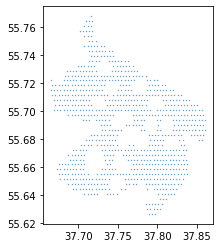

In [28]:
import geopandas as gpd 

gdf = gpd.read_file('data/grid_for_sites.geojson')
gdf.plot(markersize=.1)

In [31]:
sited = gdf.loc[gdf.geo_id.isin(tt)]
print(sited.shape)

(18, 2)


In [34]:
sited.to_file('data/sited_locs.geojson', driver="GeoJSON")

In [23]:
# Percentage of the population covered by the cell towers built is computed as follows.
total_population = 0

for region in range(len(regions)):
    total_population += population[region]

coverage = round(100*m.objVal/total_population, 2)

print(f"\n The population coverage associated to the cell towers build plan is: {coverage} %")


 The population coverage associated to the cell towers build plan is: 83.97 %
